# Spotting the Problem

It is good to know how well the trains run according to the schedule and the on-time-performance impact on the customers of BART. What is even better is figuring out what are the potential problems where delays are introduced.

Rather than look at entire journey, we look at the individual segments. Delays are introduced in runs between stations. These stack up and eventually add upto significant impact on the total journey times for customers. So in this notebook, we will walk through how we can identify potential bottlenecks.

We do this by comparing the scheduled travel times with the actual travel times between pairs of stations. The travel times here may identify segments that have chronic issues/delays and help direct the next step analysis. 

In [1]:
import pandas as pd
# Configure some display options for panda frames to ensure we see all columns and rows when needed.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 6)
pd.set_option('display.max_colwidth', -1)

import datetime as dt

# Ensure we embedd the graphs we generate within the Notebook
%matplotlib inline

import numpy as np
from scipy import stats

import seaborn as sns
sns.set(color_codes=True)
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

import pickle

import pprint

In [2]:
class TravelStatistics(object):
    def __init__(self, start, end, list_travel_times):
        """Given a TravelRecord with multiple trips, generates statistics including:
         * stats.describe.
         * median (i.e. p50
         * p90
         * p99
         * p99.9
         """
        self._start = start
        self._end = end
        np_array = np.sort(np.fromiter(list_travel_times, np.float))
        
        percentiles = np.percentile(np_array, [50, 75, 90, 95, 99])
        self._p50 = percentiles[0]
        self._p75 = percentiles[1]
        self._p90 = percentiles[2]
        self._p95 = percentiles[3]
        self._p99 = percentiles[4]
        
        stats_obj = stats.describe(np_array)
        self._nobs = stats_obj.nobs
        self._min = stats_obj.minmax[0]
        self._max = stats_obj.minmax[1]
        self._mean = stats_obj.mean
        self._variance = stats_obj.variance
        self._skewness = stats_obj.skewness
        self._kurtosis = stats_obj.kurtosis
        self._mode = stats.mode(np_array)
        #DescribeResult(nobs=238, minmax=(150.0, 4908.0), mean=649.90756302521004, 
        # variance=391391.05471049179, skewness=2.975446304980173, kurtosis=11.555424995051435)
        
    def __str__(self):
        ret = "start={}, end={}".format(self._start, self._end)
        ret += ", nobs={}, min={}, max={}, mode={}".format(self._nobs, self._min, self._max, self._mode)
        ret += ", p50={}, p75={}, p90={}, p95={}, p99={}".format(self._p50, self._p75, self._p90, self._p95, self._p99)
        ret += ", mean={}, variance={}".format(self._mean, self._variance)
        ret += ", skewness={}, kurtosis={}".format(self._skewness, self._kurtosis)        
        return ret

    def __repr__(self):
        return self.__str__() 



In [78]:
class TravelRecord(object):
    def __init__(self, row_a, row_b):
        """Represents a TravelRecord between two locations, including the start, end times as well as durations."""
        self._location_a = row_a['location']
        self._location_b = row_b['location']
        self._start_time = row_a['received_time']
        self._end_time = row_b['received_time']
        self._travel_time_secs = (self._end_time - self._start_time).total_seconds()
        
    def __str__(self):
        ret = "{} @ {} --[{}]--> {} @ {}".format(self._location_a, self._start_time, self._travel_time_secs, self._location_b, self._end_time)
        return ret
    
    def __repr__(self):
        #ret = "{} @ {} --[{}]--> {} @ {}".format(self._location_a, self._start_time, self._travel_time_secs, self._location_b, self._end_time)
        return self.__str__()

## Datasets

First we will load the the datasets we produced in other notebooks.

In [3]:
map_actual_travel_times = {}
with open('actual_travel_time_stats.pickle', 'rb') as handle:
    map_actual_travel_times = pickle.loads(handle.read())

In [4]:
pprint.pprint(map_actual_travel_times['M80']['M90'])

[start=M80, end=M90, nobs=1647, min=7.0, max=16207.0, mode=ModeResult(mode=array([ 507.]), count=array([10])), p50=543.0, p75=767.0, p90=1380.4, p95=2138.5, p99=4049.32, mean=744.21797207, variance=879536.92269, skewness=6.86607674932, kurtosis=76.0343081172]


In [5]:
map_scheduled_travel_times = {}
with open('schedule_travel_time_stats.pickle', 'rb') as handle:
    map_scheduled_travel_times = pickle.loads(handle.read())

In [6]:
pprint.pprint(map_scheduled_travel_times['M80']['M90'])

[start=M80, end=M90, nobs=543, min=226.0, max=256.0, mode=ModeResult(mode=array([ 256.]), count=array([299])), p50=256.0, p75=256.0, p90=256.0, p95=256.0, p99=256.0, mean=242.519337017, variance=223.102485168, skewness=-0.203625508646, kurtosis=-1.95853665223]


In [79]:
map_travel_records = {}
with open('actual_travel_time.pickle', 'rb') as handle:
    map_travel_records = pickle.loads(handle.read())

In [7]:
time_table = pd.read_csv('tt_of_interest_no_index.csv')

In [8]:
time_table.head()

,SCH_DAY_TYPE_CODE,ROUTE_B_NUMBER,TRAIN_NUMBER,RUN_U_NUMBER,STATION_O_NUMBER,STATION_CH3_ABBR,STATION_NAME,DOOR_CLOSE_TIME,DOOR_CLOSE_TSEC,DOOR_OPEN_TSEC,LINE_NUMBER,ROUTE_ABBR,MAP_COLOR_NAME,FROM_STATION_O_NUM,TO_STATION_O_NUM,FROM_STATION_CH3_ABBR,TO_STATION_CH3_ABBR,FROM_STATION,TO_STATION
0,SA,1,361,5,41,C80,WEST PITTSBURG,2017-08-15 06:58:23,25103,24983.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
1,SA,1,361,5,40,C70,NORTH CONCORD,2017-08-15 07:04:30,25470,25455.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
2,SA,1,361,5,19,C60,CONCORD,2017-08-15 07:08:04,25684,25669.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
3,SA,1,361,5,18,C50,PLEASANT HILL,2017-08-15 07:13:28,26008,25993.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
4,SA,1,361,5,17,C40,WALNUT CREEK,2017-08-15 07:16:05,26165,26150.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT


Lets build up a look up table to quickly identify the STATION_NAME and MAP_COLOR_NAME

In [68]:
station_name_color = time_table[['STATION_CH3_ABBR','STATION_NAME', 'MAP_COLOR_NAME']].sort_values('STATION_CH3_ABBR')
station_name_color = station_name_color.drop_duplicates()
station_name_color.set_index('STATION_CH3_ABBR', inplace=True)
station_name_color.shape

(107, 2)

In [72]:
type(station_name_color.loc['M10'].STATION_NAME[0])

str

In [49]:
station_name_color

,STATION_NAME,MAP_COLOR_NAME
STATION_CH3_ABBR,,
C80,WEST PITTSBURG,YELLOW
C70,NORTH CONCORD,YELLOW
C60,CONCORD,YELLOW
C50,PLEASANT HILL,YELLOW
C40,WALNUT CREEK,YELLOW
C30,LAFAYETTE,YELLOW
C20,ORINDA,YELLOW
C10,ROCKRIDGE,YELLOW
K30,MACARTHUR,YELLOW


## Comparison


In [77]:
match = 0
no_match = 0
for start, nested in map_actual_travel_times.iteritems():
    for end, actual_travel_stats in nested.iteritems():
        
        if start in map_scheduled_travel_times:
            if end in map_scheduled_travel_times[start]:
                
                start_name = station_name_color.loc[start].STATION_NAME
                if type(start_name) is not str:
                    start_name = start_name[0]
                end_name = station_name_color.loc[end].STATION_NAME
                if type(end_name) is not str:
                    end_name = end_name[0]
                
                schedule_travel_stats = map_scheduled_travel_times[start][end][0]
                expected_duration = schedule_travel_stats._mode.mode[0]
                actual_duration_median = actual_travel_stats[0]._p50
                print "({}){} -> ({}){}: Expected={} vs {}=Actual".format(start, start_name,end, end_name, expected_duration,actual_duration_median)
                #print "Match: {} -> {}: {}\n".format(start, end, travel_stats)
                #print "   vs: {}\n".format(schedule_travel_stats)
                match += 1
            else:
                no_match += 1
        else:
            no_match += 1
            
print "There were {} matches and {} no matches".format(match, no_match)

(M70)GLEN PARK            -> (M60)24TH STREET MISSION : Expected=164.0 vs 398.0=Actual
(M70)GLEN PARK            -> (M80)BALBOA PARK         : Expected=137.0 vs 315.5=Actual
(M50)16TH STREET MISSION  -> (M60)24TH STREET MISSION : Expected=121.0 vs 237.0=Actual
(M50)16TH STREET MISSION  -> (M40)CIVIC CENTER        : Expected=142.0 vs 296.0=Actual
(C50)PLEASANT HILL        -> (C40)WALNUT CREEK        : Expected=157.0 vs 374.5=Actual
(C50)PLEASANT HILL        -> (C60)CONCORD             : Expected=299.0 vs 937.5=Actual
(L10)CASTRO VALLEY        -> (A50)BAY FAIR            : Expected=285.0 vs 808.0=Actual
(A80)UNION CITY           -> (A90)FREMONT             : Expected=270.0 vs 730.5=Actual
(A80)UNION CITY           -> (A70)SOUTH HAYWARD       : Expected=311.0 vs 811.0=Actual
(M30)POWELL STREET        -> (M40)CIVIC CENTER        : Expected=90.0 vs 153.0=Actual
(M30)POWELL STREET        -> (M20)MONTGOMERY STREET   : Expected=101.0 vs 153.0=Actual
(A50)BAY FAIR             -> (A60)HAYWARD   

## Distributions and Graphs


Actual Times:
[start=K10, end=M10, nobs=764, min=189.0, max=18903.0, mode=ModeResult(mode=array([ 419.]), count=array([5])), p50=772.0, p75=1059.0, p90=1456.4, p95=2219.8, p99=6359.06, mean=957.760471204, variance=1354974.22695, skewness=7.80605395233, kurtosis=90.7867627006]
Schedule Times:
[start=K10, end=M10, nobs=292, min=268.0, max=268.0, mode=ModeResult(mode=array([ 268.]), count=array([292])), p50=268.0, p75=268.0, p90=268.0, p95=268.0, p99=268.0, mean=268.0, variance=0.0, skewness=0.0, kurtosis=-3.0]
2219.8


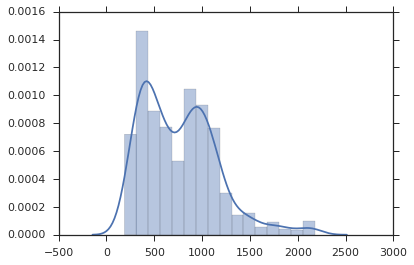

In [97]:
#pprint.pprint(map_travel_records['R20']['R10'])
A = 'K10'
B = 'M10'
list_travel_recs = map_travel_records[A][B]
actual_stats = map_actual_travel_times[A][B]
schedule_times = map_scheduled_travel_times[A][B]

print "Actual Times:"
pprint.pprint(actual_stats)
print "Schedule Times:"
pprint.pprint(schedule_times)

cutoff = actual_stats[0]._p95
print cutoff
list_times = [x._travel_time_secs for x in list_travel_recs if (x._travel_time_secs < cutoff)]

#pprint.pprint(list_times)

sns.distplot(list_times);
